# Modelling:
- This notebook uses the data obtained from Pre-Processing notebook

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa
import multiprocessing as mp
import re
import pickle
import time

In [2]:
# Random Seed for Reproducibility
tf.keras.utils.set_random_seed(442)

In [3]:
# GPU Usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Set memory growth
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

Num GPUs Available:  1


2022-05-22 14:07:06.968913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 14:07:07.010707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 14:07:07.010862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
labeldict = {
    'Sadness': 0,
    'Excited': 1,
    'Happiness': 2,
    'Anger' : 3,
    'Frustration' : 4,
    'Other' : 5
}

In [5]:
def one_hot_encode(label):
    one_hot = np.zeros(6)
    one_hot[labeldict[label]] = 1
    return one_hot

In [6]:
def one_hot_encode_list(listOfLabels):
    finalList = []
    for label in listOfLabels:
        finalList.append(one_hot_encode(label))
    return np.array(finalList)

In [7]:
def get_STFT_and_label(path):
    emotion = re.match('.*/DATA/([a-zA-Z]+)/.*', path).groups()[0]
    data, _ = librosa.load(path, sr=44100)
    STFT = np.abs(librosa.stft(data))
    return STFT, emotion

In [8]:
def preprocess_input(pathList): # Returns a list of x (batch_size, timesteps, feature), y (one_hot_encoded)
    with mp.Pool() as p:
        results = p.map(get_STFT_and_label, pathList)
    # Preprocess x:
    x = [item[0] for item in results]
    # Flatten
    x = [item for sublist in x for item in sublist]
    # Zero-padding:
    x = keras.preprocessing.sequence.pad_sequences(x, padding="post", maxlen=1497, dtype = np.float32) # maxlen is after discovering the whole training data
    # Reshaping so that the order is not messed up
    x = x.reshape(-1, 1025, 1497)
    # Transposing so that we have timesteps in dim 1
    x = x.transpose((0, 2, 1))
    # Preprocess y:
    y = [item[1] for item in results]
    # one_hot_encode
    y = one_hot_encode_list(y)
    return x, y

# Loading data: 
- We will load the data per predefined batch size, this is to reduce the memory used for training:

In [9]:
with open('train_paths.pkl', 'rb') as f:
    train_paths = pickle.load(f)
with open('test_paths.pkl', 'rb') as f:
    test_paths = pickle.load(f)

### Verify the order is preserved:

In [10]:
a, b=preprocess_input(train_paths[:32])

In [11]:
a[0]

array([[8.8433094e-02, 1.3021269e-01, 1.4366210e-01, ..., 7.1329065e-04,
        7.1328791e-04, 7.1328570e-04],
       [2.4098808e-01, 3.4502932e-01, 3.7759700e-01, ..., 3.5598411e-04,
        3.5598440e-04, 3.5597730e-04],
       [1.0744733e-01, 4.3875551e-01, 4.3909615e-01, ..., 1.9026218e-10,
        5.0048090e-09, 3.9142600e-09],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [12]:
ap, _ = get_STFT_and_label(train_paths[0])

In [13]:
ap.T

array([[8.84330943e-02, 1.30212694e-01, 1.43662095e-01, ...,
        7.13290647e-04, 7.13287911e-04, 7.13285699e-04],
       [2.40988076e-01, 3.45029324e-01, 3.77597004e-01, ...,
        3.55984113e-04, 3.55984404e-04, 3.55977303e-04],
       [1.07447334e-01, 4.38755512e-01, 4.39096153e-01, ...,
        1.90262181e-10, 5.00480901e-09, 3.91426003e-09],
       ...,
       [1.86033726e-01, 3.90104949e-01, 4.49180543e-01, ...,
        1.15817738e-08, 7.79957610e-09, 2.30712938e-09],
       [6.79136366e-02, 1.73671320e-01, 1.22675106e-01, ...,
        4.54663714e-05, 4.54557012e-05, 4.54601577e-05],
       [9.56224501e-02, 1.32804841e-01, 1.33970708e-01, ...,
        1.33038717e-04, 1.33034511e-04, 1.33032721e-04]], dtype=float32)

In [14]:
# Make batches of the pathList:
def create_batches(pathList, batch_size):
    ansList = [] # To store the final batched paths
    tempList = [] # Temporary list
    count = 0
    while count < len(pathList):
        tempList.append(pathList[count]) # Append the path
        count += 1
        if (count % batch_size) == 0: # if count is a multiple of batch_size
            ansList.append(tempList)
            tempList = []
    if len(tempList) != 0: # If tempList is not empty
        ansList.append(tempList) # Append the remaining values
    return ansList

In [15]:
# Load the validation datasets. The validation datasets are loaded entirely to the machine.
x_val, y_val = preprocess_input(test_paths)

In [16]:
x_val.shape

(1200, 1489, 1025)

# Modelling:

In [17]:
# # Keras API:
# inp = layers.Input(shape=(None, 1025))
# x = layers.Masking(mask_value=0.0)(inp)
# total_seq, final_hidden_state, final_cell_state = layers.LSTM(256, return_state=True)(x)
# x = layers.Dense(512, activation='relu')(final_hidden_state)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dense(6, activation='softmax')(x)

# model = keras.Model(inp, x)

In [17]:
# # Keras API: LSTM
# inp = layers.Input(shape=(None, 1025))
# x = layers.Masking(mask_value=0.0)(inp)
# lstm1, final_hidden_state1, final_cell_state1 = layers.LSTM(256, return_state=True, return_sequences=True)(x)
# lstm2, final_hidden_state2, final_cell_state2 = layers.LSTM(256, return_state=True, return_sequences=True)(lstm1, initial_state=[final_hidden_state1, final_cell_state1])
# lstm3, final_hidden_state3, final_cell_state3 = layers.LSTM(256, return_state=True)(lstm2, initial_state=[final_hidden_state2, final_cell_state2])
# concatenated = layers.Concatenate()([final_hidden_state3, final_cell_state3]) # concatenate the hidden state and cell state to make use of the information
# x = layers.Flatten()(concatenated) # Flattening the hidden state
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.Dense(6, activation='softmax')(x)

# model = keras.Model(inp, x)

In [21]:
# Keras API: RNN + CNN
inp = layers.Input(shape=(1489, 1025))

conv1 = layers.Conv1D(64, 3)(inp)
batchnorm1 = layers.BatchNormalization()(conv1)
maxpool1 = layers.MaxPool1D(3)(batchnorm1)

conv2 = layers.Conv1D(64, 3)(maxpool1)
batchnorm2 = layers.BatchNormalization()(conv2)
maxpool2 = layers.MaxPool1D(3)(batchnorm2)

conv3 = layers.Conv1D(64, 3)(maxpool2)
batchnorm3 = layers.BatchNormalization()(conv3)
maxpool3 = layers.MaxPool1D(3)(batchnorm3)

flattened = layers.Flatten()(maxpool3)

x = layers.Dense(256, activation='relu')(flattened)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(6, activation='softmax')(x)

model = keras.Model(inp, x)

In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1489, 1025)]      0         
                                                                 
 conv1d_6 (Conv1D)           (None, 1487, 64)          196864    
                                                                 
 batch_normalization_6 (Batc  (None, 1487, 64)         256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 495, 64)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 493, 64)           12352     
                                                                 
 batch_normalization_7 (Batc  (None, 493, 64)          256 

# Training the model

In [23]:
# Batch_size is 32, epochs = 30
batch_size = 32
epochs = 30

In [24]:
# Optimizer is Stochastic Gradient Descent
# Loss function is Categorical Crossentropy
optimizer = keras.optimizers.SGD()
loss_fn = keras.losses.CategoricalCrossentropy()

In [25]:
training_batch = create_batches(train_paths, batch_size=batch_size)
validation_batch = create_batches(test_paths, batch_size=batch_size)

In [26]:
# Metrics:
train_metrics = tf.keras.metrics.CategoricalAccuracy()
validation_metrics = tf.keras.metrics.CategoricalAccuracy()
train_loss = tf.keras.metrics.CategoricalCrossentropy()
validation_loss = tf.keras.metrics.CategoricalCrossentropy()

In [27]:
# A list to store epoch results:
epoch_accuracy_train = []
epoch_accuracy_val = []
epoch_loss_train = []
epoch_loss_val = []

In [28]:
# To speed up, use graph execution
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training = True)
        loss = loss_fn(y, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # Update training accuracy
    train_metrics.update_state(y, y_pred)
    # Update training loss:
    train_loss.update_state(y, y_pred)
    return loss

In [29]:
@tf.function
def valid_step(x, y):
    y_val_pred = model(x, training=False)
    # Update metrics for validation
    validation_metrics.update_state(y, y_val_pred)
    validation_loss.update_state(y, y_val_pred)
    return

In [30]:
for epoch in range(epochs):
    start_time = time.time()
    print("\nStart of epoch %d" % (epoch+1))
    for step, batch in enumerate(training_batch):
        x, y = preprocess_input(batch)
        
        loss = train_step(x, y)
        
        # Log every 200 batches.
        if step % 10 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
    
    # Display metrics at the end of each epoch.
    train_acc = train_metrics.result()
    print("Training acc over epoch: %.4f" % (float(train_acc)))
    loss_train = train_loss.result()
    print("Training loss over epoch: %.4f" % (float(loss_train)))
    
    # Reset training metrics at the end of each epoch
    train_metrics.reset_states()
    train_loss.reset_states()
    
    # For validation data:
    for val_batch in validation_batch:
        x_val, y_val = preprocess_input(val_batch)
        
        valid_step(x_val, y_val)
        

    # Metrics
    val_acc = validation_metrics.result()
    loss_val = validation_loss.result()
    validation_metrics.reset_states()
    validation_loss.reset_states()
    
    # Append to a list for graph:
    epoch_accuracy_train.append(train_acc)
    epoch_accuracy_val.append(val_acc)
    epoch_loss_train.append(loss_train)
    epoch_loss_val.append(loss_val)
    
    print("Validation acc: %.4f" % (float(val_acc)))
    print("Validation loss: %.4f" % (float(loss_val)))
    print("Time taken: %.2fs" % (time.time() - start_time))



Start of epoch 1


2022-05-22 14:10:12.190435: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-22 14:10:13.783421: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Training loss (for one batch) at step 0: 1.9474
Seen so far: 32 samples
Training loss (for one batch) at step 10: 1.7161
Seen so far: 352 samples
Training loss (for one batch) at step 20: 1.7999
Seen so far: 672 samples
Training loss (for one batch) at step 30: 1.7671
Seen so far: 992 samples
Training loss (for one batch) at step 40: 1.6444
Seen so far: 1312 samples
Training loss (for one batch) at step 50: 1.5879
Seen so far: 1632 samples
Training loss (for one batch) at step 60: 1.7164
Seen so far: 1952 samples
Training loss (for one batch) at step 70: 1.7452
Seen so far: 2272 samples
Training loss (for one batch) at step 80: 1.8175
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 1.6476
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 1.5553
Seen so far: 3232 samples
Training loss (for one batch) at step 110: 1.8433
Seen so far: 3552 samples
Training loss (for one batch) at step 120: 1.7205
Seen so far: 3872 samples
Training loss (for one batch

Training loss (for one batch) at step 80: 0.9543
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 1.1550
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 0.8943
Seen so far: 3232 samples
Training loss (for one batch) at step 110: 1.1143
Seen so far: 3552 samples
Training loss (for one batch) at step 120: 1.4890
Seen so far: 3872 samples
Training loss (for one batch) at step 130: 0.9872
Seen so far: 4192 samples
Training loss (for one batch) at step 140: 1.3431
Seen so far: 4512 samples
Training acc over epoch: 0.5971
Training loss over epoch: 1.1129
Validation acc: 0.3475
Validation loss: 1.6884
Time taken: 226.03s

Start of epoch 8
Training loss (for one batch) at step 0: 1.0617
Seen so far: 32 samples
Training loss (for one batch) at step 10: 0.9820
Seen so far: 352 samples
Training loss (for one batch) at step 20: 0.9012
Seen so far: 672 samples
Training loss (for one batch) at step 30: 0.9956
Seen so far: 992 samples
Training loss (for one bat

Validation acc: 0.3217
Validation loss: 2.4758
Time taken: 222.62s

Start of epoch 14
Training loss (for one batch) at step 0: 0.8989
Seen so far: 32 samples
Training loss (for one batch) at step 10: 0.6512
Seen so far: 352 samples
Training loss (for one batch) at step 20: 0.6854
Seen so far: 672 samples
Training loss (for one batch) at step 30: 0.5562
Seen so far: 992 samples
Training loss (for one batch) at step 40: 0.6938
Seen so far: 1312 samples
Training loss (for one batch) at step 50: 0.7643
Seen so far: 1632 samples
Training loss (for one batch) at step 60: 0.9071
Seen so far: 1952 samples
Training loss (for one batch) at step 70: 0.8381
Seen so far: 2272 samples
Training loss (for one batch) at step 80: 0.4636
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 1.1180
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 0.6612
Seen so far: 3232 samples
Training loss (for one batch) at step 110: 0.5306
Seen so far: 3552 samples
Training loss (for

Training loss (for one batch) at step 70: 0.5549
Seen so far: 2272 samples
Training loss (for one batch) at step 80: 0.2829
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 0.4341
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 0.4658
Seen so far: 3232 samples
Training loss (for one batch) at step 110: 0.1869
Seen so far: 3552 samples
Training loss (for one batch) at step 120: 0.7493
Seen so far: 3872 samples
Training loss (for one batch) at step 130: 0.4410
Seen so far: 4192 samples
Training loss (for one batch) at step 140: 0.5259
Seen so far: 4512 samples
Training acc over epoch: 0.8452
Training loss over epoch: 0.4797
Validation acc: 0.3458
Validation loss: 2.4911
Time taken: 226.26s

Start of epoch 21
Training loss (for one batch) at step 0: 0.3568
Seen so far: 32 samples
Training loss (for one batch) at step 10: 0.3350
Seen so far: 352 samples
Training loss (for one batch) at step 20: 0.4626
Seen so far: 672 samples
Training loss (for one b

Training acc over epoch: 0.9592
Training loss over epoch: 0.1602
Validation acc: 0.3225
Validation loss: 3.6077
Time taken: 226.90s

Start of epoch 27
Training loss (for one batch) at step 0: 0.1173
Seen so far: 32 samples
Training loss (for one batch) at step 10: 0.1044
Seen so far: 352 samples
Training loss (for one batch) at step 20: 0.1756
Seen so far: 672 samples
Training loss (for one batch) at step 30: 3.4549
Seen so far: 992 samples
Training loss (for one batch) at step 40: 1.0321
Seen so far: 1312 samples
Training loss (for one batch) at step 50: 0.8080
Seen so far: 1632 samples
Training loss (for one batch) at step 60: 1.3780
Seen so far: 1952 samples
Training loss (for one batch) at step 70: 0.6346
Seen so far: 2272 samples
Training loss (for one batch) at step 80: 0.4819
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 0.6085
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 0.3201
Seen so far: 3232 samples
Training loss (for one batch)

# Plotting:

In [31]:
import matplotlib.pyplot as plt

In [32]:
axis_x = [i+1 for i in range(epochs)]

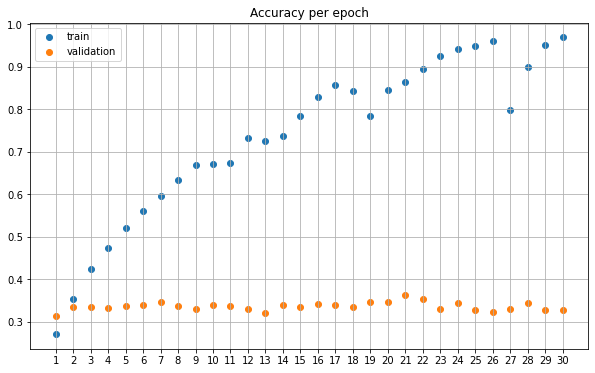

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x = axis_x, y = epoch_accuracy_train, label = "train")
ax.scatter(x = axis_x, y = epoch_accuracy_val, label="validation")
ax.legend()
ax.grid()
ax.set_title("Accuracy per epoch")
ax.set_xticks(ticks = axis_x)
plt.show()

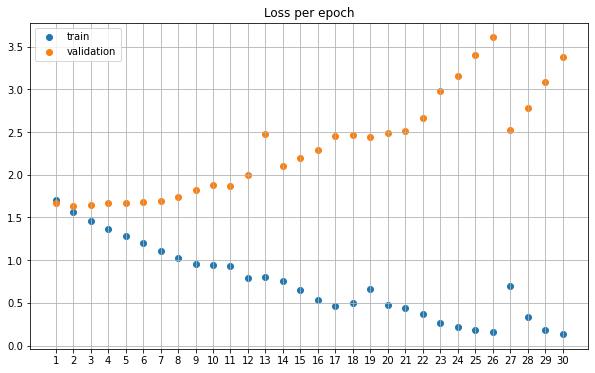

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = axis_x, y = epoch_loss_train, label="train")
ax.scatter(x = axis_x, y = epoch_loss_val, label="validation")
ax.legend()
ax.grid()
ax.set_title("Loss per epoch")
ax.set_xticks(ticks = axis_x)
plt.show()